In [1]:
from __future__ import division, print_function

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['lines.linewidth'] = 0.75

import numpy as np
import pandas as pd
def df_repr_latex(self):
    return '\n'.join([
        r'\vspace{5mm}',
        r'{\scriptsize{\centering{%s}}}' % self.to_latex(),
        r'\vspace{5mm}'
    ])
pd.DataFrame._repr_latex_ = df_repr_latex
from pandas.formats.style import Styler
Styler._repr_latex_ = lambda s: s.data._repr_latex_()

class HTMLLatex:
    def __init__(self, html, latex):
        self.html = html
        self.latex = latex
    def _repr_html_(self): return self.html
    def _repr_latex_(self): return self.latex
NewPage = HTMLLatex('<hr>', r'\clearpage\newpage')

from IPython.display import display, HTML, Latex

from dcmfetch import fetch_series
from mriqa.reports import (
    ghosting_report, slice_profile_report, distortion_report,
    resolution_bars_report, uniformity_report, snr_report
)
from mriqa.phantoms import SIEMENSSHORTBOTTLE

from mriqa.xmlqa.coilqa import (
    find_qa_results_file,
    coil_snr, coil_snr_history, coil_name, coil_names,
    plot_coil_images, 
    MINCOILSERNO
)

from dcmextras.siemenscsa import csa

# Percent above specification
MARGIN = 5 
margin_colour = lambda x: 'color: %s' % ('green' if x>= MARGIN else 'orange' if x>0 else 'red')
ok_colour     = lambda x: 'color: %s' % ('green' if x else 'red')

from datetime import datetime

import fmriqa

# MRI Physics QA -  BHI Avanto
- Tests Performed:
  - Slice shape and Profile
  - Distortion and Field of View
  - In Plane Resolution
  - Ghosting
  - Head Coil SNR
  - Head Coil Image Uniformity
  - PC Flow Background

All of the above are acceptable.


In [2]:
text = '''
R. Hartley-Davies, J. Delve. S. Curtis, H. Elbert
Medical Physics & Bioengineering, UH Bristol
January 2018
'''
display(HTMLLatex(
    r'<pre>' + text + r'</pre>',
    r'\vfill' + '\n' + r'\begin{verbatim}' + '\n' + text + '\n' + r'\end{verbatim}' + '\n'
))


In [3]:
NewPage

## Slice Profile

These are the profiles of 3mm and 5mm slices in a conventional spin echo with a of T<sub>E</sub> of 30ms.

### 3 mm Slice

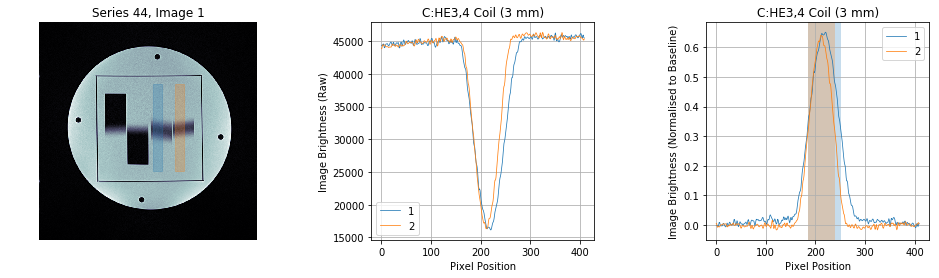

Plate Angle  =  11.7 degrees
FWHM     (1) =  66.9 pixels, or 3.4 mm
FWHM     (2) =  53.6 pixels, or 2.7 mm
FWHM (GMEAN) =  59.9 pixels, or 3.0 mm


In [4]:
# TO2: Slice 3mm
patid = 'PQA20180120BHIAVANTO'
stuid = '1'

# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[44])
slice_idx = 0
results = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

### 5 mm Slice

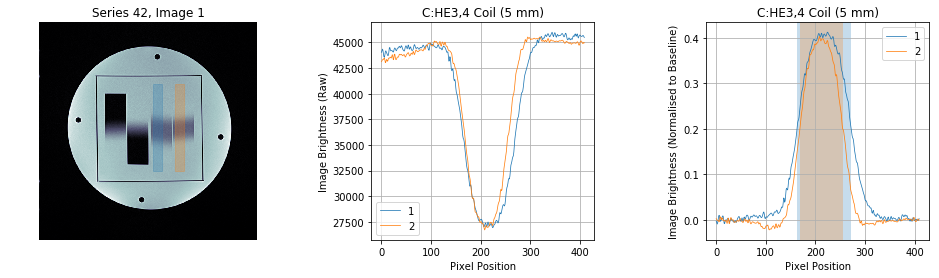

Plate Angle  =  11.7 degrees
FWHM     (1) =  107.9 pixels, or 5.5 mm
FWHM     (2) =  85.9 pixels, or 4.3 mm
FWHM (GMEAN) =  96.3 pixels, or 4.9 mm


In [5]:
# TO2: Slice 5mm
# Distortion Corrected, Phase RL, Uniformity Corrected 512*512
dobjs = fetch_series(patid, stuid, sernos=[42])
slice_idx = 0
result = slice_profile_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)
results = results.append(result)

In [6]:
pd.set_option('precision', 1)
results[['FWHMGMeanPixels', 'FWHMGMeanMM']]

FWHMGMeanPixels  FWHMGMeanMM
SliceThickness                              
3.0                        59.9          3.0
5.0                        96.3          4.9

These are both with the AAPM tolerance of 0.5mm.

In [7]:
NewPage

## Geometric Distortion and Scaling

The TO2 phantom has a square box for distortion and scale measurements.

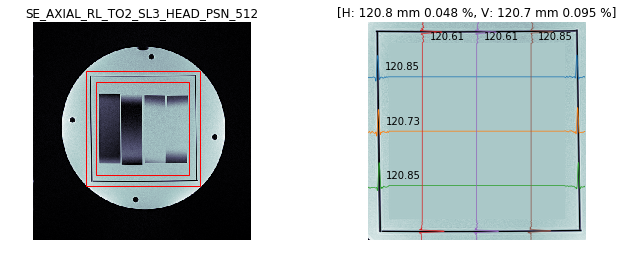

Horizontal Scale / Distortion:    120.8 mm / 0.05 %
Vertical Scale / Distortion:      120.7 mm / 0.10 %


In [8]:
# TO2: Distortion
# SE: Axial, Phase RL, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[44])

slice_idx = len(dobjs) // 2
results = distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False)

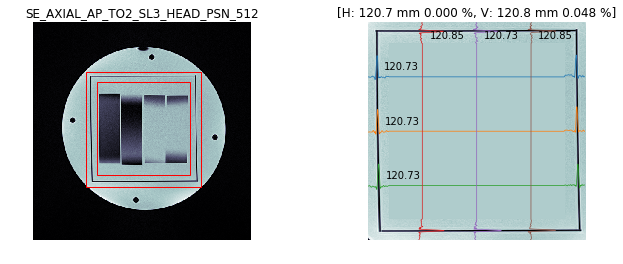

Horizontal Scale / Distortion:    120.7 mm / 0.00 %
Vertical Scale / Distortion:      120.8 mm / 0.05 %


In [9]:
# TO2: Distortion
# SE: Axial, Phase AP, 512 matrix
dobjs = fetch_series(patid, stuid, sernos=[46])

slice_idx = len(dobjs) // 2
results = results.append(distortion_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=False))

In [10]:
pd.set_option('precision', 3)
results[['Orientation', 'PhaseDirection', 'Sensitivity', 'HorizontalScale', 'HorizontalDistortion','VerticalScale', 'VerticalDistortion' ]]

Orientation PhaseDirection  Sensitivity  HorizontalScale  \
Series                                                            
44           Axial             RL        0.239          120.809   
46           Axial             AP        0.239          120.728   

        HorizontalDistortion  VerticalScale  VerticalDistortion  
Series                                                           
44                     0.048        120.687               0.095  
46                     0.000        120.809               0.048

The image scale is within 1% of the expected value. Distortion (arising from both gradient nonlinearity and field inhomogeneity) is acceptable at the bandwidth used (130Hz/pixel).

In [11]:
NewPage

## Spatial Resolution

The resolution is assessed using the TO4 phantom, which has parallel plates of various separations. These are results for the highest resolution scan (1024x10124).

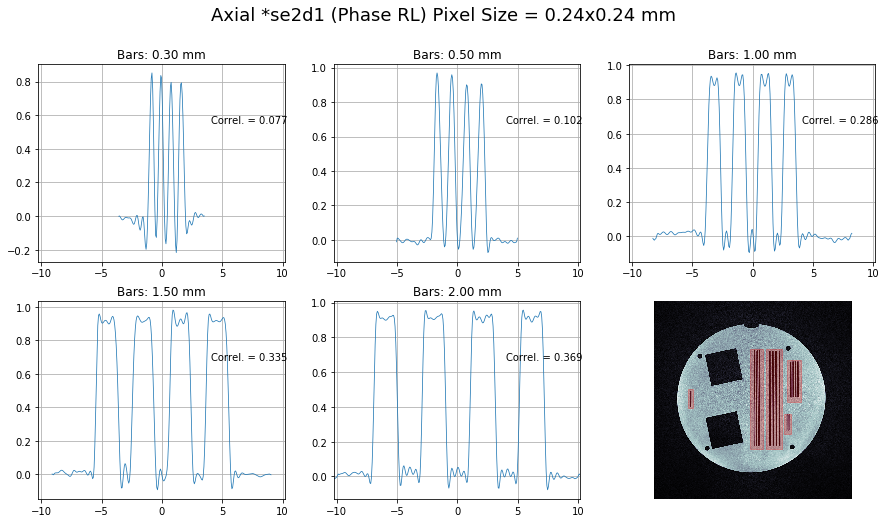

In [12]:
# TO4: Resolution
dobjs = fetch_series(patid, stuid, sernos=[48])
slice_idx = 0
result = resolution_bars_report(dobjs[slice_idx], flipped_ud=False, flipped_rl=True)

All the features are adequately resolved.

In [13]:
NewPage

## Ghosting

Image ghosting is asesssed following the approach of [AAPM report 100](https://www.aapm.org/pubs/reports/RPT_100.pdf) for the transverse orientation and three example sequences.

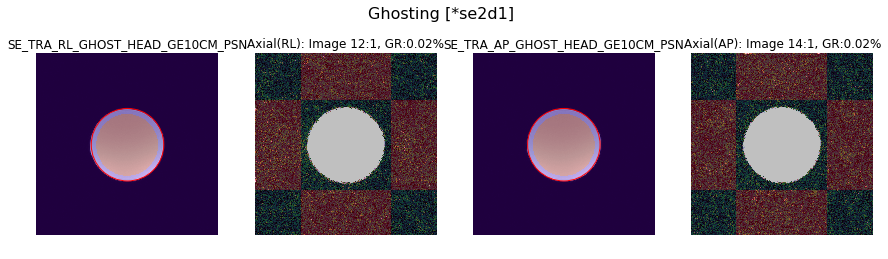

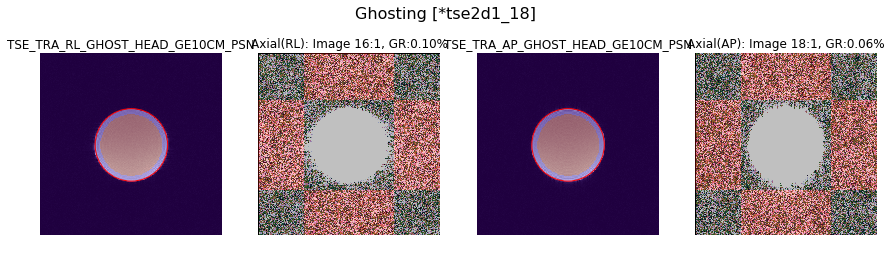

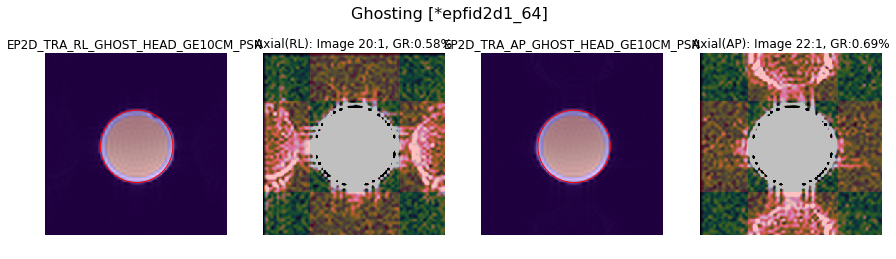

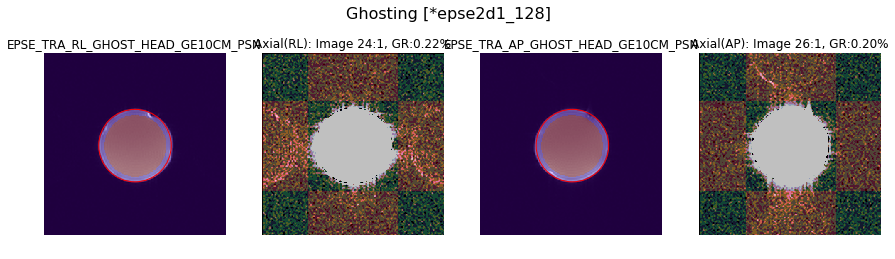

Sequence Orientation PhaseDirection  GhostRatio
Series                                                     
12            *se2d1       Axial             RL      0.0237
14            *se2d1       Axial             AP      0.0206
16        *tse2d1_18       Axial             RL      0.0985
18        *tse2d1_18       Axial             AP      0.0608
20      *epfid2d1_64       Axial             RL      0.5834
22      *epfid2d1_64       Axial             AP      0.6899
24      *epse2d1_128       Axial             RL      0.2173
26      *epse2d1_128       Axial             AP      0.2038

In [14]:
# GE10CM: Ghosting

# SE Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [12, 14]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = ghosting_report(dobjs, axes=list(axs.flat))

# TSE18 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [16, 18]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))

# EPI64 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [20, 22]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

# EPISE128 Axial
dobjs = [fetch_series(patid, stuid, sernos=[serno])[0] for serno in [24, 26]]
_, axs = plt.subplots(1, 4, figsize=(15, 4))
results = results.append(ghosting_report(dobjs, axes=list(axs.flat)))
plt.show()

pd.set_option('precision', 4)
display(results[['Sequence', 'Orientation', 'PhaseDirection', 'GhostRatio']])

The level of ghosting is low (less than 1%) for SE, TSE, and SE-EPI. The gradient echo EPI ghosting is above 1% though when the secondary read-out direction is right-left.

In [15]:
NewPage

## Receiver Coil Uniformity

We have tested the uniformity of the standard head coil using a silicone oil filled spherical phantom. Results are presented both before and after Siemens `prescan-normalise` intensity correction.

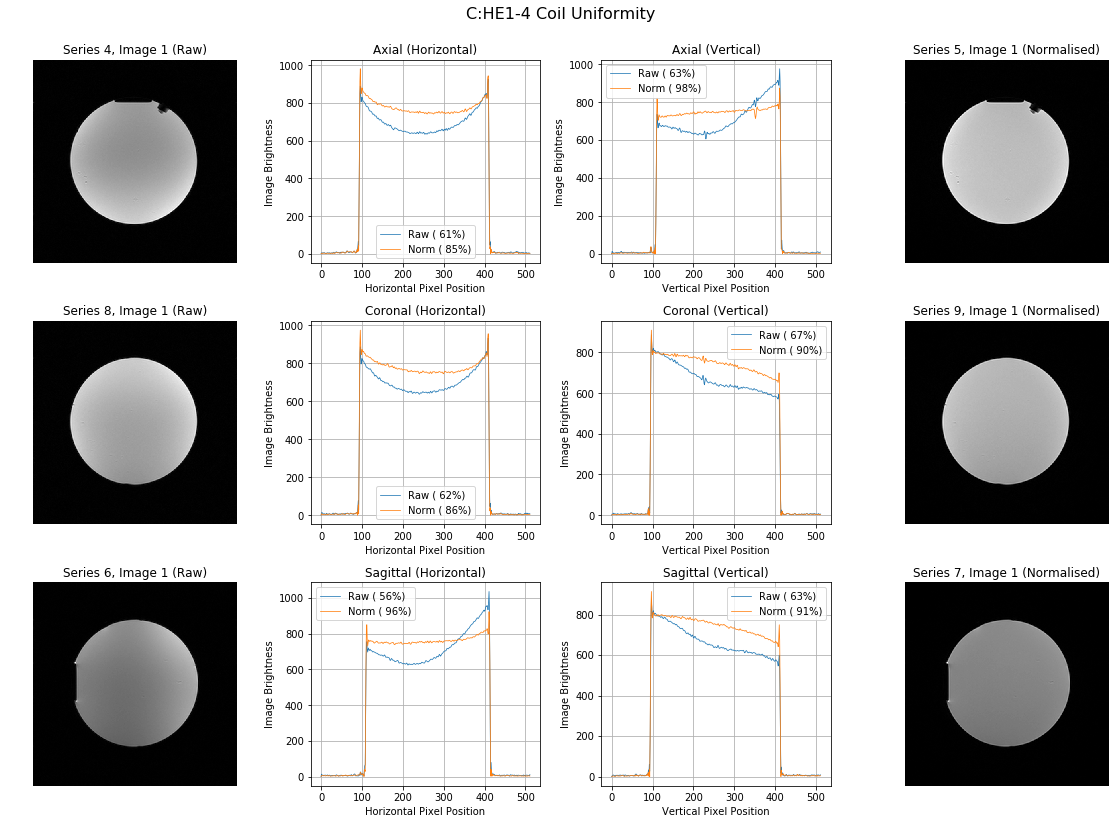

Raw Images


SeriesRaw                      ProtocolRaw    OrientRaw  \
Axial             4  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal           8  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/RL   
Sagittal          6  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

          XUniformityRaw  YUniformityRaw  
Axial                 61              63  
Coronal               62              67  
Sagittal              56              63

Intensity Normalised Images


SeriesNorm                     ProtocolNorm   OrientNorm  \
Axial              5  SE_TRA_RL_UNIF_HEAD_OIL20CM_PSN     Axial/RL   
Coronal            9  SE_COR_FH_UNIF_HEAD_OIL20CM_PSN   Coronal/RL   
Sagittal           7  SE_SAG_AP_UNIF_HEAD_OIL20CM_PSN  Sagittal/AP   

          XUniformityNorm  YUniformityNorm  
Axial                  85               98  
Coronal                86               90  
Sagittal               96               91

In [16]:
# OILSPHERE: Uniformity
# SE Axial,Coronal,Sagittal; w w/o Intensity Normalization

#### TODO normalised images missing ###
raw_tra = fetch_series(patid, stuid, sernos=[4])
psn_tra = fetch_series(patid, stuid, sernos=[5])
raw_sag = fetch_series(patid, stuid, sernos=[6])
psn_sag = fetch_series(patid, stuid, sernos=[7])
raw_cor = fetch_series(patid, stuid, sernos=[8])
psn_cor = fetch_series(patid, stuid, sernos=[9])

if len(raw_tra) > 1:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
        raw_dobjsb=[raw_tra[1], raw_sag[1], raw_cor[1]],
        psn_dobjsb=[psn_tra[1], psn_sag[1], psn_cor[1]]
    )
else:
    results = uniformity_report(
        raw_dobjs=[raw_tra[0], raw_sag[0], raw_cor[0]],
        psn_dobjs=[psn_tra[0], psn_sag[0], psn_cor[0]],
    )

plt.show()

pd.set_option('precision', 0)
print('Raw Images')
display(results[['SeriesRaw',  'ProtocolRaw',  'OrientRaw', 'XUniformityRaw', 'YUniformityRaw']])
print('Intensity Normalised Images')
display(results[['SeriesNorm', 'ProtocolNorm', 'OrientNorm', 'XUniformityNorm', 'YUniformityNorm']])

There are relatively few elements in this head coil but the the uncorrected images are still significantly non-uniform especially in the AP direction. The Siemens `prescan-normalise` intensity correction is adequate in compensating for this.

In [17]:
NewPage

## Signal to Noise

The Siemens QA involves a comprehensive element by element assessment of the SNR of all the coils. For reference purposes the following is an independent estimate for the standard head coil using the Siemens long bottle phantom (this can easily be positioned reproducibly). The SNR is estimated over centred discs with diameters 50% and 75% of the phantom. The signal is taken from the mean of two images within the phantom and noise estimated from a background region in their difference.

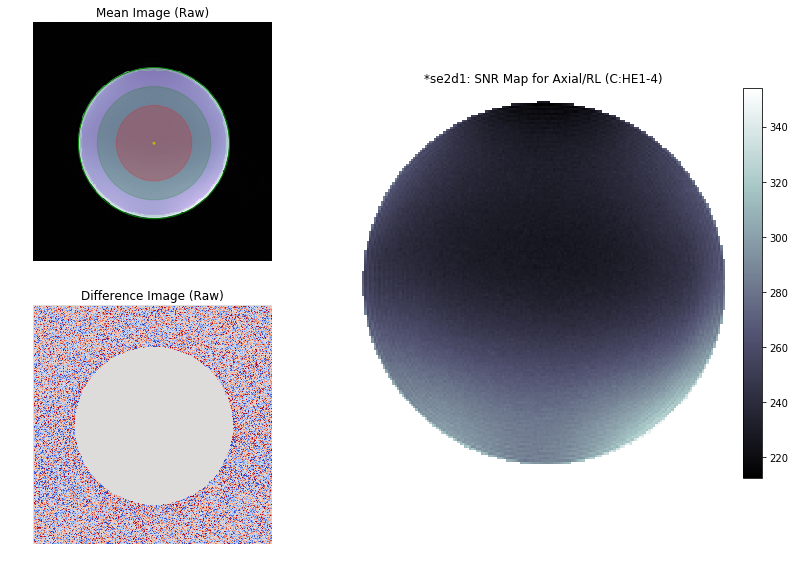

SNR: Raw Images


C:HE1-4
0.50    237.0
0.75    245.0

In [18]:
# LONGBOTTLE: Signal to Noise
raw_tra = fetch_series(patid, stuid, sernos=[31, 33])
if len(raw_tra) > 1:
    results = snr_report(raw_dobjs=[raw_tra[0]], raw_dobjsb=[raw_tra[1]], phantom=SIEMENSSHORTBOTTLE)
else:
    results = snr_report(raw_dobjs=[raw_tra[0]], phantom=SIEMENSSHORTBOTTLE)
plt.show()

pd.set_option('precision', 2)
print('SNR: Raw Images')
display(np.round(results))

These results are similar to the those we have obtained on other 1.5T Siemens scanners under these conditions.

In [19]:
NewPage

## Phase Contrast Velocity Offsets

In [20]:
from scipy.ndimage.filters import gaussian_filter
from scipy.stats import scoreatpercentile
from itertools import groupby
from skimage.filters import threshold_minimum

def true_z_offset(dobj):
    """
    The Z position of the centre of the slice

    Parameters
    ----------
    dobj: pydicom dicom object
        an image slice

    Returns
    -------
    float: distance along z axis from isocentre in mm
    """
    # direction cosines
    _, _, rowz, _, _, colz = dobj.ImageOrientationPatient
    # position of centre of corner pixel
    _, _, z = dobj.ImagePositionPatient
    # distance to centre along columns and rows
    ny, nx = dobj.Rows, dobj.Columns
    dy, dx = dobj.PixelSpacing
    # projection of vector to centre onto z using cosines
    return z + rowz * (nx / 2) * dx + colz * (ny / 2) * dy


def contour_levels(vals, levels=21):
    """
    Generate a reasonable (and symmetric) set of contour levels for data
    on the assumption that it is signed data.

    Parameters
    ----------
    vals: ndarray
        image values
    levels: int
        number of contour levels

    Returns
    -------
    ndarray: vector of contour levels
    """
    rough_max = scoreatpercentile(np.abs(vals.flat), 99)
    assert rough_max > 0 
    rough_step = rough_max / (levels / 2)
    assert rough_step > 1e-3

    # Round to 1 significant figure
    rounding = -int(np.floor(np.log10(rough_step)))

    rounded_step = np.round(rough_step, rounding)
    rounded_max  = np.round(rough_max, rounding)
    positive_levels = np.arange(0, rounded_max, rounded_step)
    negative_levels = -positive_levels[:0:-1]
    return np.concatenate([negative_levels, positive_levels])

def plot_offsets(magnitude, phase, zlocations, title):
    """
    Plot phase offsets in subplots. Show image overlaid with contours.

    Parameters
    ----------
    magnitude: sequence of ndarray
        stack of magnitude images
    phase: sequence of ndarray
        stack of phase images
    zlocations: sequence of int
        z locations of slice centres in integer mm
    title: str
        super-title for plot
    """
    # Check same no. of slices
    nslices = len(magnitude)
    assert nslices == len(phase)
    
    # Mask out background
    threshold = threshold_minimum(magnitude)
    bgmask = magnitude < threshold
    phase[bgmask] = 0

    # Set contour levels and image brightness scale
    levels = contour_levels(phase)
    clim = levels[0], levels[-1]
    
    # Plot layout
    ncols = 3
    nrows = int(np.ceil(float(nslices) / ncols))
    fig, axs = plt.subplots(nrows, ncols, squeeze=True, figsize=(6*ncols*1.1, 4*nrows))

    # Plots
    contoursets = []
    for i in range(nslices):
        ax = axs[i//ncols][i%ncols]
        ax.imshow(phase[i], cmap='bone', clim=clim)
        ax.hold(True)
        ax.axis('off')

        # Smooth and mask background again to get smooth contours
        smoothed = gaussian_filter(phase[i], 4, mode='nearest')
        smoothed[bgmask[i]] = 0

        contoursets.append(
            ax.contour(
                smoothed,
                levels=levels, cmap='seismic',
                vmin=clim[0], vmax=clim[1]
            )
        )
        ax.set_title('Z=%+dmm' % zlocations[i] if zlocations[i] != 0 else 'Z=0')

    # Dummy images to fill out subplot array
    for i in range(nslices, nrows*ncols):
        ax = axs[i//ncols][i%ncols]
        ax.imshow(np.zeros_like(phase[0]), cmap='bone', clim=clim)
        ax.axis('off')

    # Global colour bar    
    cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])

    # Kludge to get a colour bar that covers the full range of all the slices
    mappable = plt.cm.ScalarMappable(cmap='bone', norm=plt.Normalize(vmin=clim[0], vmax=clim[1]))
    mappable.set_array([])
    cbar = fig.colorbar(mappable, cax=cax, ticks=levels, label='cm/sec')
    for contourset in contoursets:
        cbar.add_lines(contourset, erase=False)

    fig.suptitle(title, fontsize=24)


def phase_background_report(dobjs_magnitude, dobjs_phase, plane, transpose=False):
    """
    Report on backgound phase variation in flow images of 'Jerry Can' phantom.
    A series of cardiac gated images phase contrast flow images at various
    offsets in Z are used.

    Parameters
    ----------
    dobjs_magnitude: list of pydicom dicom objects
        (flow corrected) magnitude images
    dobjs_phase: list of pydicom dicom objects
        phase (velocity) images
    plane: str
        label for orientation of slices
    transpose: bool
        transpose images for display
 
    Returns
    -------
    """
    dobjs_magnitude = sorted(
        dobjs_magnitude,
        key=lambda d: (int(round(true_z_offset(d))), float(d.TriggerTime))
    )
    dobjs_phase = sorted(
        dobjs_phase,
        key=lambda d: (int(round(true_z_offset(d))), float(d.TriggerTime))
    )

    magnitude_objs_by_slice = {
        k: list(v) for k, v in groupby(dobjs_magnitude, key=lambda d: int(round(true_z_offset(d))))
    }

    magnitude_av = {
        k: np.mean(np.asarray([d.pixel_array for d in dobjs]), axis=0).T if transpose else
           np.mean(np.asarray([d.pixel_array for d in dobjs]), axis=0)
        for (k, dobjs) in magnitude_objs_by_slice.items()
    }

    phase_objs_by_slice = {
        k: list(v) for k, v in groupby(dobjs_phase, key=lambda d: int(round(true_z_offset(d))))
    }
    phase_av = {
        k: np.mean([d.pixel_array for d in dobjs], axis=0).T if transpose else
           np.mean(np.asarray([d.pixel_array for d in dobjs]), axis=0)
        for k, dobjs in phase_objs_by_slice.items()
    }

    zlocations = list(phase_av.keys())
    phase = np.asarray(list(phase_av.values()))
    magnitude = np.asarray(list(magnitude_av.values()))

    # Calibrate to cm/sec
    rescale_slope, rescale_intercept = dobjs_phase[0].RescaleSlope, dobjs_phase[0].RescaleIntercept
    venc = csa(dobjs_phase[0], 'image')['FlowVenc']
    phase = venc * (phase * rescale_slope + rescale_intercept) / 4096

    # Plot results
    plot_offsets(magnitude, phase, zlocations, title='Phase Background: %s Plane (VENC=%d cm/s)' % (plane, venc))


These are cardiac gated flow encoded acquisitions of a large gel phantom with slice orientations representative of aortic and pulmonary artery studies. The acquistions are repeated at different displacements along the bore of the scanner. The plots shows the baseline velocity error over the volume of the phantom in cm/s.

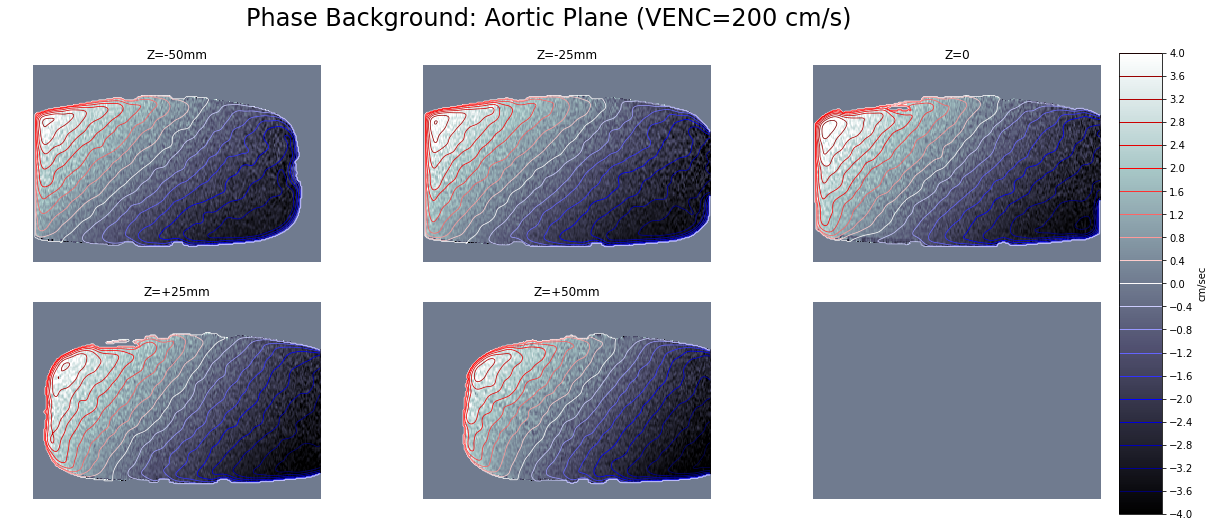

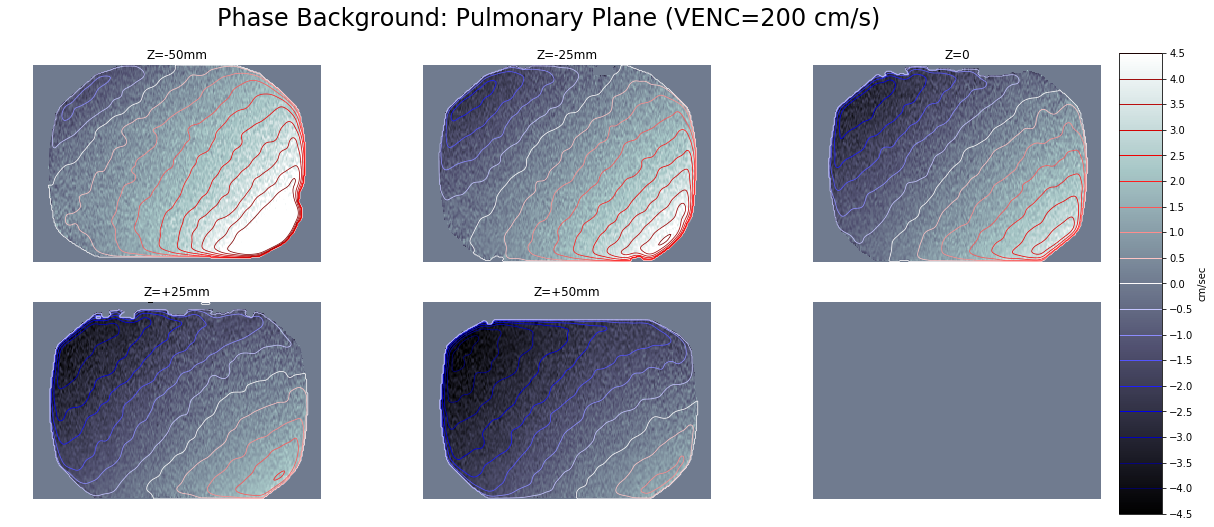

In [21]:
phase_background_report(
    dobjs_magnitude=fetch_series(patid, stuid=stuid, sernos=list(range(55, 70, 3))),
    dobjs_phase=fetch_series(patid, stuid=stuid, sernos=list(range(57, 70, 3))),
    plane='Aortic', transpose=True
)

phase_background_report(
    dobjs_magnitude=fetch_series(patid, stuid=stuid, sernos=list(range(73, 88, 3))),
    dobjs_phase=fetch_series(patid, stuid=stuid, sernos=list(range(75, 88, 3))),
    plane='Pulmonary', transpose=False
)

Errors of the order of 1-2 cm/s are to be expected in cardiac flow measurement unless this background is allowed for. They increase strongly away from the magnet isocentre.